In [30]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import scipy.stats as stats
import seaborn as sns
import statistics
import tensorflow as tf
import time

from collections import namedtuple
from tensorflow.python.keras.models import clone_model, load_model, Model
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Input, concatenate
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
# from keras.optimizers import adam
from tensorflow.python.keras.initializers import Zeros, Ones, Constant, he_normal, truncated_normal
from tensorflow.python.keras import backend
from tensorflow.keras.layers import BatchNormalization

# Import custom classes
# from Classes.generators import generatorWienerProcess, generatorGeometricBM
# from Classes.callOptionBlackScholes import callOption
from Classes.callOptionBlackScholes import call_option
from Classes.generators import geometric_brownian_generator, wiener_process_generator

# Reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Brains, Agents, Environments, and Trainers

# Brains

In [31]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

# Initialize the Replay Buffer class
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []                # a circular queue
        self.index = 0
    
    # push a new tuple to the buffer
    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        self.memory[self.index] = Transition(state, action, next_state, reward)
        self.index = (self.index + 1) % self.capacity
        
    # sample a random batch for training
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    # return the buffer length
    def __len__(self):
        return len(self.memory)

In [32]:
class BrainDelta:
    def __init__(self, num_states, num_actions, is_rounded = True):
        self.num_states = num_states
        self.num_actions = num_actions
        self.is_rounded = is_rounded
    
    def replay(self):
        return
    
    def decide_action(self, state, episode=None):
        if self.is_rounded:
            return np.round(state[3])
        else:
            return state[3]

In [33]:
# optimizer = tf.keras.optimizers.Adam()

In [59]:
class BrainDQN:
    
    def __init__(self, num_states, num_actions):
        
        self.num_states = num_states
        self.num_actions = num_actions
        self.freq_update_target = FREQ_UPDATE_TARGET
        self.count_replay = 0
        self.memory = ReplayMemory(CAPACITY)
        
        # Construct a neural network
        input_dim = self.num_states
        output_dim = self.num_actions
        hidden_layers = [16, 16,]
        activation_func = 'relu'
        k_init = he_normal(seed=0)
        # optimizer = Adam(lr=0.001)
        # optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        
        self.model = Sequential()
        for i, fan_in in enumerate( ([input_dim,]+hidden_layers)[:-1] ):
            fan_out = hidden_layers[i]
            self.model.add(Dense(input_dim=fan_in, units=fan_out, kernel_initializer=k_init))
            # self.model.add(BatchNormalization())
            self.model.add(Activation(activation_func))
        self.model.add(Dense(units=output_dim, kernel_initializer=truncated_normal(seed=0)))
        
        # print(self.model)
        
        # Set how to train the model
        self.model.compile(loss='mse', optimizer="adam",)
        self._target_model = clone_model(self.model)
    
    def save(self, file_name):
        self.model.save(file_name)
    
    def load(self, file_name):
        self.model = load_model(file_name)
        self._target_model = clone_model(self.model)
    
    def replay(self):
        
        if len(self.memory) < BATCH_SIZE: return
        
        # Make mini batch
        transitions = self.memory.sample(BATCH_SIZE)
        transitions = list(zip(*transitions))
        
        states = np.array(transitions[0])
        actions = np.array(transitions[1])
        n_states = np.array(transitions[2])
        rewards = np.array(transitions[3])
        
        X = np.zeros_like(states)
        for i, n_s in enumerate(n_states): 
            if n_s is not None:
                X[i, :] = n_s
            else:
                X[i, :] = states[i, :]
        n_q = np.max(self._target_model.predict(X), axis=1)
        
        # Make targets for regression
        q = self.model.predict(states)
        for i, n_s in enumerate(n_states): 
            r = rewards[i]
            a = actions[i]
            if n_s is not None:
                r += GAMMA*n_q[i]
            q[i,a] = r
        
        # Update weight parameters
        loss = self.model.train_on_batch(states, q)
        
        self.count_replay += 1
        if self.count_replay % self.freq_update_target == 0:
            self.update_target_model()
    
    def decide_action(self, state, episode=None):
        
        if episode is not None:
            epsilon = 0.5 * (1 / (episode + 1))
        else:
            epsilon = 0
        
        p = np.random.uniform(0,1)
        if p >= epsilon:
            state = np.array(state).reshape(1,-1)
            action = np.argmax(self.model.predict(state)[0])
        else:
            action = np.random.randint(0, self.num_actions)
        
        return action
    
    def update_target_model(self):
        self._target_model.set_weights(self.model.get_weights())

In [60]:
# This class is implemented referring to the below:
# https://github.com/germain-hug/Deep-RL-Keras/tree/master/DDPG
class Actor:
    
    def __init__(self, env_dim, act_dim, act_range, lr, tau):
        self.env_dim = env_dim
        self.act_dim = act_dim
        self.act_range = act_range
        self.tau = tau
        self.lr = lr
        
        # Make models and optimizer
        self.model = self.network()
        self.target_model = self.network()
        self.my_optimizer = self.optimizer()
    
    def network(self):
        inp = Input(shape=(self.env_dim,))
        x = Dense(12, activation='relu', kernel_initializer=he_normal(seed=0))(inp)
        x = Dense(12, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        x = Dense(12, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        out = Dense(self.act_dim, activation='linear', kernel_initializer=truncated_normal(seed=0))(x)
        return Model(inp, out)
    
    def make_action(self, state):
        # the input is a state vector [shape = (self.env_dim,)]
        action = self.model.predict(np.expand_dims(state, axis=0)) # shape (self.env_dim,) --> (1, self.env_dim)
        return action
    
    def target_predict(self, states):
        # the input is state vectors [shape = (batch_size, self.env_dim)]
        return self.target_model.predict(states)
    
    def transfer_weights(self):
        W, target_W = self.model.get_weights(), self.target_model.get_weights()
        for i in range(len(W)):
            target_W[i] = self.tau * W[i] + (1.0 - self.tau) * target_W[i]
        self.target_model.set_weights(target_W)
    
    def train(self, states, actions, grads):
        # grads = dQ / da_i
        # calculate the total grads [i.e., sum_i (-1) *(dQ/da_i) * (da_i / dw_j)] and apply them to the actor weights w_j.
        self.my_optimizer([states, grads])
    
    def optimizer(self):
        action_gdts = backend.placeholder(shape=(None, self.act_dim)) # = dQ/da_i
        params_grad = tf.gradients(self.model.output, self.model.trainable_weights, -action_gdts) # = sum_i (-1) *(dQ/da_i) * (da_i / dw_j)
        grads = zip(params_grad, self.model.trainable_weights)
        return backend.function([self.model.input, action_gdts], outputs=[], updates=[tf.train.GradientDescentOptimizer(self.lr).apply_gradients(grads),])
    
    def save(self, path):
        self.model.save(path + '_actor.h5')
    
    def load(self, path):
        self.model = load_model(path + '_actor.h5')

In [61]:
# This class is implemented referring to the below:
# https://github.com/germain-hug/Deep-RL-Keras/tree/master/DDPG
class Critic:
    
    def __init__(self, env_dim, act_dim, lr, tau):
        self.env_dim = env_dim
        self.act_dim = act_dim
        self.tau = tau
        self.lr = lr
        
        # Make models
        self.model = self.network()
        self.target_model = self.network()
        # self.model.compile(Adam(self.lr), 'mse')
        # self.target_model.compile(Adam(self.lr), 'mse')
        self.model.compile(optimizer = "Adam", metrics='mse')
        self.target_model.compile(optimizer = "Adam", metrics='mse')
        
        # Function to compute Q-value gradients wrt action (= dQ/da_i)
        # input[0]: state, input[1]: action
        self.action_grads = backend.function([self.model.input[0], self.model.input[1]], [backend.gradients(self.model.output, [self.model.input[1],]),])
    
    def network(self):
        state = Input(shape=(self.env_dim,))
        action = Input(shape=(self.act_dim,))
        x = concatenate([state, action])
        x = Dense(24, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        x = Dense(24, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        x = Dense(24, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        out = Dense(1, activation='linear', kernel_initializer=truncated_normal(seed=0))(x)
        return Model([state, action], out) # = Q(s,a)
    
    def gradients(self, states, actions):
        return self.action_grads([states, actions]) # = dQ/da_i
    
    def target_predict(self, inputs):
        # inputs are [states, actions]
        return self.target_model.predict(inputs)
    
    def train(self, states, actions, critic_targets):
        return self.model.train_on_batch([states, actions], critic_targets)
    
    def transfer_weights(self):
        W, target_W = self.model.get_weights(), self.target_model.get_weights()
        for i in range(len(W)):
            target_W[i] = self.tau * W[i] + (1.0 - self.tau)* target_W[i]
        self.target_model.set_weights(target_W)
    
    def save(self, path):
        self.model.save(path + '_critic.h5')
    
    def load(self, path):
        self.model = load_model(path + '_critic.h5')

# Agents

In [62]:
class AgentActionValueBase:
    def __init__(self, brain):
        self.brain = brain
    
    def update_agent(self):
        self.brain.replay()
    
    def get_action(self, state, step=None, episode=None):
        action = self.brain.decide_action(state, episode)
        return action
    
    def memorize(self, state, action, state_next, reward):
        self.brain.memory.push(state, action, state_next, reward)

In [63]:
# The below three classes are copied from the below:
# https://github.com/keras-rl/keras-rl/blob/master/rl/random.py

class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma

class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = np.random.normal(self.mu,self.current_sigma,self.size)

In [64]:
class AgentDDPG:
    
    def __init__(self, env_dim, act_dim, act_range, random_process=None, actor_lr=1e-3, critic_lr=1e-3, tau=1e-3):
        self.env_dim = env_dim
        self.act_dim = act_dim
        self.act_range = act_range
        
        self.episode = 0
        self.random_process =  random_process
        if random_process is not None:
            self.random_process.reset_states()
        
        # Make models and memory
        self.actor = Actor(self.env_dim, self.act_dim, self.act_range, actor_lr, tau)
        self.critic = Critic(self.env_dim, self.act_dim, critic_lr, tau)
        self.memory = ReplayMemory(CAPACITY)
    
    def get_action(self, s, step=None, episode=None):
        
        if self.random_process is None:
            
            if episode is not None:
                epsilon = 0.5 * (1 / (episode + 1))
            else:
                epsilon = 0
            
            p = np.random.uniform(0,1)
            if p >= epsilon:
                action = np.round(self.actor.make_action(s)[0,0])
                action = np.clip(action, self.act_range[0], self.act_range[1])
            else:
                action = np.random.randint(self.act_range[0], self.act_range[1]+1)
            
        else:
            
            noise = 0
            if episode is not None:
                noise = self.random_process.sample()
            
            action = np.round(self.actor.make_action(s)[0,0]+noise)
            action = np.clip(action, self.act_range[0], self.act_range[1])
        
        return action
    
    def memorize(self, state, action, state_next, reward):
        self.memory.push(state, action, state_next, reward)
    
    def update_agent(self):
        
        if len(self.memory) < BATCH_SIZE: return
        
        # Make mini batch
        transitions = self.memory.sample(BATCH_SIZE)
        transitions = list(zip(*transitions))
        
        states = np.array(transitions[0])
        actions = np.array(transitions[1])
        n_states = np.array(transitions[2])
        rewards = np.array(transitions[3])
        
        X = np.zeros_like(states)
        for i, n_s in enumerate(n_states): 
            if n_s is not None:
                X[i, :] = n_s
        
        # Make critic targets using the target networks
        critic_targets = rewards
        n_q = self.critic.target_predict([X, self.actor.target_predict(X)])
        for i, n_s in enumerate(n_states): 
            if n_s is not None:
                critic_targets[i] += GAMMA * n_q[i]
        
        # Train critic
        self.critic.train(states, actions, critic_targets)
        
        # Q-value gradients under the current policy
        actions = self.actor.model.predict(states)
        grads = self.critic.gradients(states, actions) # = dQ/da_i
        
        # Train actor
        grads = np.array(grads).reshape((-1, self.act_dim)) # = dQ/da_i
        self.actor.train(states, actions, grads)
        
        # Transfer weights to the target networks at rate tau
        self.actor.transfer_weights()
        self.critic.transfer_weights()
    
    def save(self, path):
        self.actor.save(path)
        self.critic.save(path)
    
    def load(self, path):
        self.critic.load(path)
        self.actor.load(path)

# Environments

In [65]:
class EnvironmentBS():
    
    def __init__(self, T, n_steps, mu, ir, vol, S0, K, num_sold_opt, kappa, alpha=0):
        self.T = T
        self.n_steps = n_steps
        self.mu = mu
        self.ir = ir
        self.vol = vol
        self.S0 = S0
        self.K = K
        self.num_sold_opt = num_sold_opt
        self.kappa = kappa
        self.alpha = alpha
        self.seed = 0
        
        self.dt = T/n_steps
        self.num_states = 5
        self.num_actions = self.num_sold_opt + 1
        self.initialize_paths = False
    
    def __generate_paths(self, n_paths=10000):
        
        self.n_paths = n_paths
        self.idx_path = -1
        
        # Make stock paths
        S_paths, W_paths = geometric_brownian_generator().generate_S_and_W(self.dt, self.n_paths, self.n_steps+1, self.mu, self.vol, self.S0, self.seed)
        
        # Make time paths
        t_paths = np.zeros_like(S_paths)
        for j in range(S_paths.shape[1]): t_paths[:, j] = self.dt * j
        
        # Make option prices and deltas paths
        call_opt_paths = call_option.calc_prices(S_paths, self.K, self.ir, self.vol, self.T)
        delta_paths = call_option.calc_deltas(S_paths, self.K, self.ir, self.vol, self.T)
        
        self.S_paths = S_paths
        self.W_paths = W_paths
        self.t_paths = t_paths
        self.call_opt_paths = call_opt_paths
        self.delta_paths = delta_paths
    
    def __get_state_without_num_stocks(self, i_path, j_time):
        
        t = self.t_paths[i_path, j_time]
        W = self.W_paths[i_path, j_time]
        C = self.call_opt_paths[i_path, j_time]
        delta = self.delta_paths[i_path, j_time] * self.num_sold_opt # multiplied by num options
        num_stk = 0
        
        return np.array([t, W, C, delta, num_stk]) # state
    
    def __get_cost(self, S, chg_nS):
        return self.alpha * S * (np.abs(chg_nS) + 0.01 * chg_nS**2)
    
    def clear_all_paths(self):
        self.initialize_paths = False
    
    def reset(self):
        
        if not self.initialize_paths:
            self.__generate_paths()
            self.initialize_paths = True
        
        self.idx_path = (self.idx_path + 1) % self.n_paths
        self.idx_time = 0
        
        state = self.__get_state_without_num_stocks(self.idx_path, self.idx_time)
        self.state = state
        
        return state
    
    def step(self, action):
        
        if self.idx_time > self.n_steps:
            n_state = None
            r = np.nan
            done = True
            info = None
            
        elif self.idx_time == self.n_steps:
            n_state = None
            r = self.__get_reward(n_state)
            done = True
            info = self.__get_pv(n_state)
            
        else:
            self.idx_time += 1
            n_state = self.__get_state_without_num_stocks(self.idx_path, self.idx_time)
            n_state[4] = action # num of stocks is updated.
            r = self.__get_reward(n_state)
            done = False
            info = self.__get_pv(n_state)
        
        self.state = n_state
        
        return n_state, r, done, info
    
    def __get_reward(self, n_state=None):
        
        if n_state is None or self.state[0] == self.T:
            r = self.num_sold_opt * (np.exp(self.ir * self.T) - 1) * self.call_opt_paths[self.idx_path, 0]
            r = r / np.power(GAMMA, self.T)
            return r
        
        t1 = n_state[0]
        t0 = self.state[0]
        
        S1 =  self.S0 * np.exp(self.vol * n_state[1] + (self.mu - self.vol**2 / 2) * t1)
        S0 = self.S0 * np.exp(self.vol * self.state[1] + (self.mu - self.vol**2 / 2) * t0)
        
        C1 = n_state[2]
        C0 = self.state[2]
        
        d1 = n_state[3] # = delta per one option * num sold options
        d0 = self.state[3] # = delta per one option * num sold options
        
        nS1 = n_state[4]
        nS0 = self.state[4]
        
        r = nS1 * S1 - nS0 * S0
        r -= self.num_sold_opt * (C1 - C0)
        r -= (nS1 - nS0) * S0 * np.exp(self.ir * (self.T - t0))
        
        if self.alpha > 0:
            cost = self.__get_cost(S=S0, chg_nS=(nS1 - nS0))
            r -= cost * np.exp(self.ir * (self.T - t0))
        
        if self.kappa > 0:
            var = self.vol * S0 * (nS1 - d0)
            var = var**2 * self.dt
            r -= self.kappa * var / 2
        
        r = r / np.power(GAMMA, t0)
        
        return r
    
    def __get_pv(self, n_state=None):
        
        if n_state is None or self.state[0] == self.T:
            r = self.num_sold_opt * (np.exp(self.ir * self.T) - 1) * self.call_opt_paths[self.idx_path, 0]
            return r
        
        t1 = n_state[0]
        t0 = self.state[0]
        
        S1 =  self.S0 * np.exp(self.vol * n_state[1] + (self.mu - self.vol**2 / 2) * t1)
        S0 = self.S0 * np.exp(self.vol * self.state[1] + (self.mu - self.vol**2 / 2) * t0)
        
        C1 = n_state[2]
        C0 = self.state[2]
        
        d1 = n_state[3] # = delta per one option * num sold options
        d0 = self.state[3] # = delta per one option * num sold options
        
        nS1 = n_state[4]
        nS0 = self.state[4]
        
        r = nS1 * S1 - nS0 * S0
        r -= self.num_sold_opt * (C1 - C0)
        r -= (nS1 - nS0) * S0 * np.exp(self.ir * (self.T - t0))
        
        if self.alpha > 0:
            cost = self.__get_cost(S=S0, chg_nS=(nS1 - nS0))
            r -= cost * np.exp(self.ir * (self.T - t0))
        
        return r

# Trainers

In [66]:
class TrainerBS:
    
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
    
    def run(self, num_episodes, num_steps, seed = 999):
        
        hists = None
        self.env.clear_all_paths()
        self.env.seed = seed
        
        for episode in range(num_episodes):
            state = self.env.reset()
            if hists is None:
                hists = np.zeros(shape=(num_episodes, num_steps+1, len(state)+1))
            
            for step in range(num_steps+1):
                action = self.agent.get_action(state, None, None)
                n_state, reward, done, pv = self.env.step(action)
                
                hists[episode, step, :-1] = state
                hists[episode, step, -1] = pv
                
                if done:
                    break
                else:
                    state = n_state
        
        return hists
    
    def train(self, num_episodes, num_steps, seed = 0, num_pl_to_calc_std = 30):
        
        self.env.seed = seed
        lst_pl = []
        lst_std_pl = []
        lst_r = []
        
        for episode in range(num_episodes):
            
            state = self.env.reset()
            pl = []
            sum_r = 0
            
            for step in range(num_steps+1):
                action = self.agent.get_action(state, step=step, episode=episode)
                n_state, reward, done, pv = self.env.step(action)
                sum_r += reward * np.power(GAMMA, step)
                
                pl.append(pv)
                self.agent.memorize(state, action, n_state, reward)
                self.agent.update_agent()
                
                if done:
                    break
                else:
                    state = n_state
            
            lst_r.append(sum_r)
            pl = sum(pl)
            if len(lst_pl) < num_pl_to_calc_std:
                lst_pl.append(pl)
                lst_std_pl.append(np.nan)
            else:
                i = episode % num_pl_to_calc_std
                lst_pl[i] = pl
                std = statistics.stdev(lst_pl)
                lst_std_pl.append(std)
                if episode%20 == 0: print("Episode {}:  P&L Std = {}".format(episode, np.round(std, 2)))
        
        return lst_std_pl, lst_r

In [67]:
train_models = True

# Delta Hedging Agent

## Delta (No transaction costs)

n_steps per day = 1, AvePL = 1.00, StdPL = 36.84


/Users/jurajzelman/.local/share/virtualenvs/deep-hedging-RL-MkYESUZK/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


n_steps per day = 2, AvePL = 0.45, StdPL = 25.39


/Users/jurajzelman/.local/share/virtualenvs/deep-hedging-RL-MkYESUZK/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


n_steps per day = 4, AvePL = 0.32, StdPL = 17.57


/Users/jurajzelman/.local/share/virtualenvs/deep-hedging-RL-MkYESUZK/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


n_steps per day = 8, AvePL = 0.19, StdPL = 12.73


/Users/jurajzelman/.local/share/virtualenvs/deep-hedging-RL-MkYESUZK/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


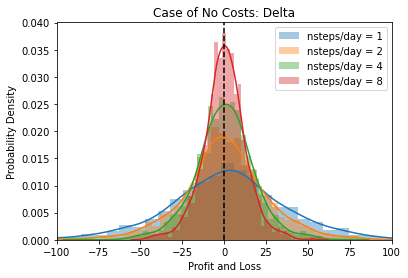

In [57]:
T = 30
NUM_STEPS = 30 * 1
MU = 0.05 / 365
IR = MU
VOL = 0.20 / np.sqrt(365)
S0 = 100
K = 100
NUM_SOLD_OPT = 100
KAPPA = 0.1
ALPHA = 0
GAMMA = 0.99

np.random.seed(7)
random.seed(7)

for NUM_STEPS in [T*1, T*2, T*4, T*8]:
    
    env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, ALPHA)
    num_states = env.num_states
    num_actions = env.num_actions
    
    brainDelta = BrainDelta(num_states, num_actions, is_rounded=True)
    agentDelta = AgentActionValueBase(brainDelta)
    
    trainer = TrainerBS(env, agentDelta)
    
    hists = trainer.run(2000, NUM_STEPS)
    pl = np.sum(hists[:, :, -1], axis=1)
    
    print('n_steps per day = {0:.0f}, AvePL = {1:.2f}, StdPL = {2:.2f}'.format(NUM_STEPS/T, pl.mean(), pl.std(ddof=1)))
    sns.distplot(pl, label="nsteps/day = {}".format(int(NUM_STEPS/T)))
    #sns.histplot(pl, label="nsteps/day = {}".format(int(NUM_STEPS/T)), kde=True, stat="density", linewidth=0)

plt.xlim(-100,100)
plt.axvline(0, color='k', ls='--')
plt.xlabel("Profit and Loss")
plt.ylabel("Probability Density")
plt.title("Case of No Costs: Delta")
plt.legend(frameon=True)
plt.show()

## Deep Q-Network (No transaction costs)

In [69]:
T = 30
NUM_STEPS = 30 * 1
MU = 0.05 / 365
IR = MU
VOL = 0.20 / np.sqrt(365)
S0 = 100
K = 100
NUM_SOLD_OPT = 100
KAPPA = 0.1
ALPHA = 0
GAMMA = 0.99
FREQ_UPDATE_TARGET = 5
CAPACITY = 10000
BATCH_SIZE = 32
file_name = './model_data/dqn_no_costs.h5'

# Filter warnings
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

np.random.seed(999)
random.seed(999)
os.environ['PYTHONHASHSEED'] = '0'
#tf.set_random_seed(999)
tf.random.set_seed(999)

env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, ALPHA)
num_states = env.num_states
num_actions = env.num_actions

brainDQN = BrainDQN(num_states, num_actions)
agentDQN = AgentActionValueBase(brainDQN)

trainer = TrainerBS(env, agentDQN)

#NUM_EPISODES = 3000
NUM_EPISODES = 200
if train_models:
    start = time.time()
    lst_std_pl, lst_r = trainer.train(NUM_EPISODES, NUM_STEPS)
    elapsed_time = time.time() - start
    print ("Elapsed Time = {0} [min]".format(np.round(elapsed_time/60.0,1)))
    brainDQN.save(file_name)

Elapsed Time = 0.6 [min]


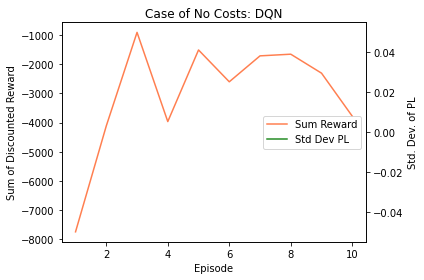

In [70]:
if train_models:
    xs = np.array(list(range(1,len(lst_std_pl)+1)))
    ys = np.array(lst_std_pl)
    zs = np.array(lst_r)
    
    fig = plt.figure(figsize=[6,4])
    
    ax = fig.add_subplot(111)
    ax.plot(xs, zs, color='coral', label='Sum Reward')
    ax.set_xlabel('Episode')
    ax.set_ylabel("Sum of Discounted Reward")
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(xs, ys, color='forestgreen', label='Std Dev PL')
    ax.set_ylabel("Std. Dev. of PL")
    h2, l2 = ax.get_legend_handles_labels()
    
    ax.legend(h1+h2, l1+l2, loc='center right')
    ax.set_title('Case of No Costs: DQN')
    plt.tight_layout()
    plt.show()

In [71]:
brainDQN = BrainDQN(num_states, num_actions)
brainDQN.load(file_name)
agentDQN = AgentActionValueBase(brainDQN)

trainer = TrainerBS(env, agentDQN)
# q_hists = trainer.run(1000, NUM_STEPS)
q_hists = trainer.run(200, NUM_STEPS)
q_pl = np.sum(q_hists[:, :, -1], axis=1)

brainDelta = BrainDelta(num_states, num_actions, is_rounded=True)
agentDelta = AgentActionValueBase(brainDelta)

trainer = TrainerBS(env, agentDelta)
# d_hists = trainer.run(1000, NUM_STEPS)
d_hists = trainer.run(200, NUM_STEPS)
d_pl = np.sum(d_hists[:, :, -1], axis=1)

/Users/jurajzelman/.local/share/virtualenvs/deep-hedging-RL-MkYESUZK/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jurajzelman/.local/share/virtualenvs/deep-hedging-RL-MkYESUZK/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


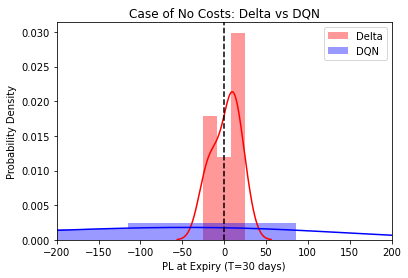

Delta: Ave = 2.17, Std = 16.33
DQN: Ave = -143.27, Std = 208.77


In [47]:
sns.distplot(d_pl, label="Delta", color='r',)
sns.distplot(q_pl, label="DQN", color='b',)
plt.axvline(0, color='k', ls='--')
plt.xlim(-200, 200)
plt.xlabel('PL at Expiry (T=30 days)')
plt.ylabel('Probability Density')
plt.title('Case of No Costs: Delta vs DQN')
plt.legend()
plt.show()

print("Delta: Ave = {0:.2f}, Std = {1:.2f}".format(d_pl.mean(), d_pl.std(ddof=1)))
print("DQN: Ave = {0:.2f}, Std = {1:.2f}".format(q_pl.mean(), q_pl.std(ddof=1)))